In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

OUTPUT_DIR = "results"

In [2]:
def preprocess_result():
    # Step 1: 读取 JSON 数据
    with open(f"{OUTPUT_DIR}/benchmark.json", "r") as f:
        data = json.load(f)

    # Step 2: 数据整理
    # 将所有的测试结果提取到一个列表中
    records = []
    for item in data:
        assert len(item["scores"]) == 1, "More than one eval splits scores founded."
        scores = list(item["scores"].values())[0][0]
        records.append(
            {
                "dataset_revision": item.get("dataset_revision", None),
                "task_name": item.get("task_name", None),
                "mteb_version": item.get("mteb_version", None),
                "evaluation_time": item.get("evaluation_time", None),
                "kg_co2_emissions": item.get("kg_co2_emissions", None),
                "model_name": item.get("model_name", None),
                "chunking_strategy": item.get("chunking_strategy", None),
                "chunk_size": item.get("chunk_size", None),
                "n_sentences": item.get("n_sentences", None),
                "chunking_model": item.get("chunking_model", None),
                "hf_subset": scores.get("hf_subset", None),
                "main_score": scores.get("main_score", None),
                "ndcg_at_1": scores.get("ndcg_at_1", None),
                "ndcg_at_3": scores.get("ndcg_at_3", None),
                "ndcg_at_5": scores.get("ndcg_at_5", None),
                "ndcg_at_10": scores.get("ndcg_at_10", None),
                "ndcg_at_20": scores.get("ndcg_at_20", None),
                "map_at_1": scores.get("map_at_1", None),
                "map_at_3": scores.get("map_at_3", None),
                "map_at_5": scores.get("map_at_5", None),
                "map_at_10": scores.get("map_at_10", None),
                "map_at_20": scores.get("map_at_20", None),
                "recall_at_1": scores.get("recall_at_1", None),
                "recall_at_3": scores.get("recall_at_3", None),
                "recall_at_5": scores.get("recall_at_5", None),
                "recall_at_10": scores.get("recall_at_10", None),
                "recall_at_20": scores.get("recall_at_20", None),
                "precision_at_1": scores.get("precision_at_1", None),
                "precision_at_3": scores.get("precision_at_3", None),
                "precision_at_5": scores.get("precision_at_5", None),
                "precision_at_10": scores.get("precision_at_10", None),
                "precision_at_20": scores.get("precision_at_20", None),
                "mrr_at_1": scores.get("mrr_at_1", None),
                "mrr_at_3": scores.get("mrr_at_3", None),
                "mrr_at_5": scores.get("mrr_at_5", None),
                "mrr_at_10": scores.get("mrr_at_10", None),
                "mrr_at_20": scores.get("mrr_at_20", None),
                "languages": scores["languages"][0] if scores["languages"] else None,
            }
        )

    # 转换为 Pandas DataFrame
    df = pd.DataFrame(records)

    return df

In [3]:

df = preprocess_result()

In [4]:
avg_scores = df.groupby(['chunking_strategy', 'chunk_size', 'model_name'])['main_score'].mean().reset_index()

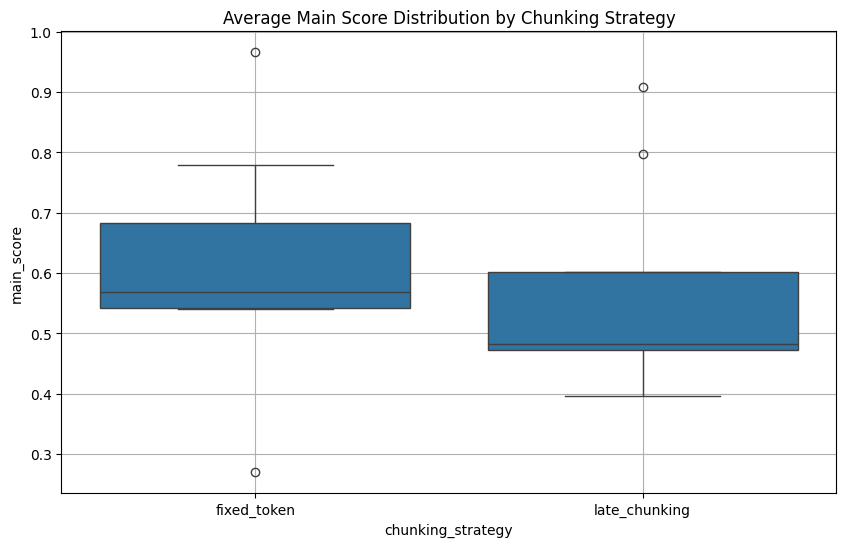

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='chunking_strategy', y='main_score', data=avg_scores)
plt.title('Average Main Score Distribution by Chunking Strategy')
plt.grid(True)
plt.show()

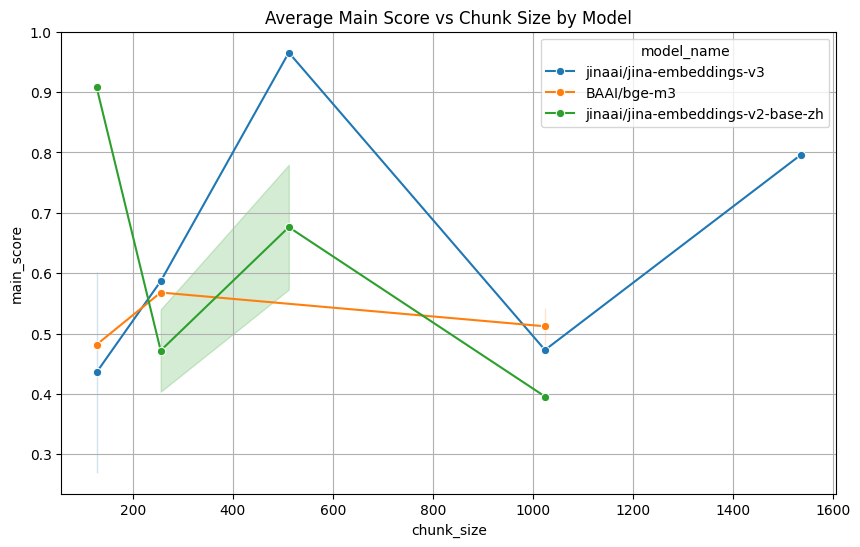

In [6]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='chunk_size', y='main_score', hue='model_name', data=avg_scores, marker='o')
plt.title('Average Main Score vs Chunk Size by Model')
plt.grid(True)
plt.show()

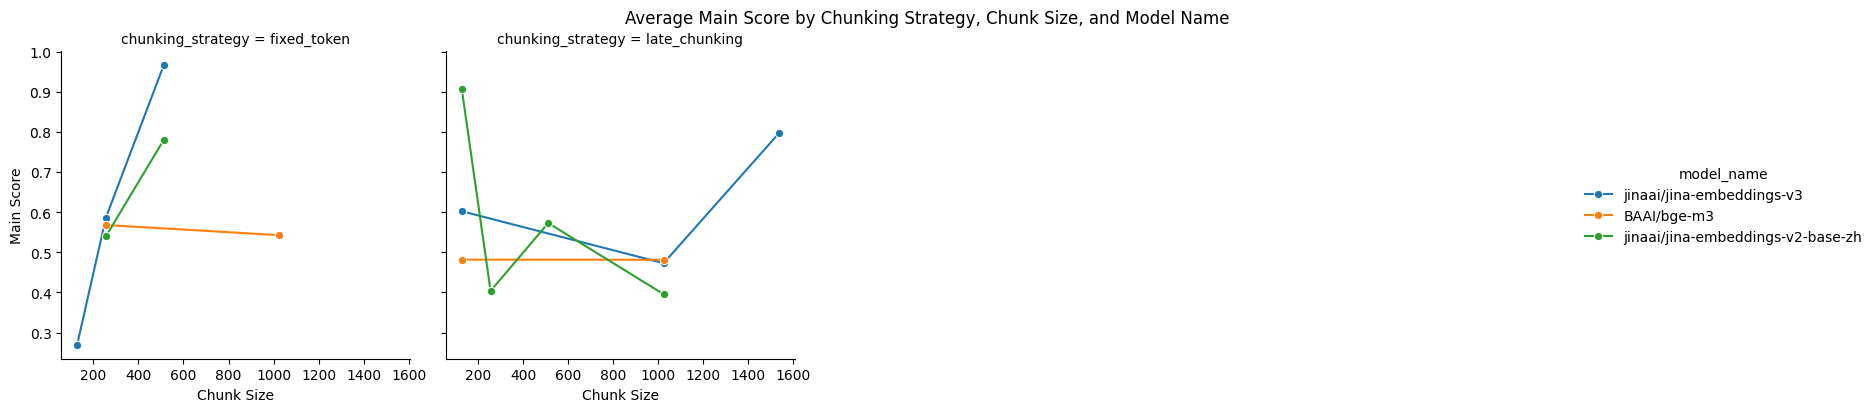

In [7]:
g = sns.FacetGrid(avg_scores, col="chunking_strategy", hue="model_name", col_wrap=4, height=4)
g.map(sns.lineplot, "chunk_size", "main_score", marker="o")
g.add_legend()
g.set_axis_labels("Chunk Size", "Main Score")
g.fig.suptitle('Average Main Score by Chunking Strategy, Chunk Size, and Model Name', y=1.02)
plt.show()

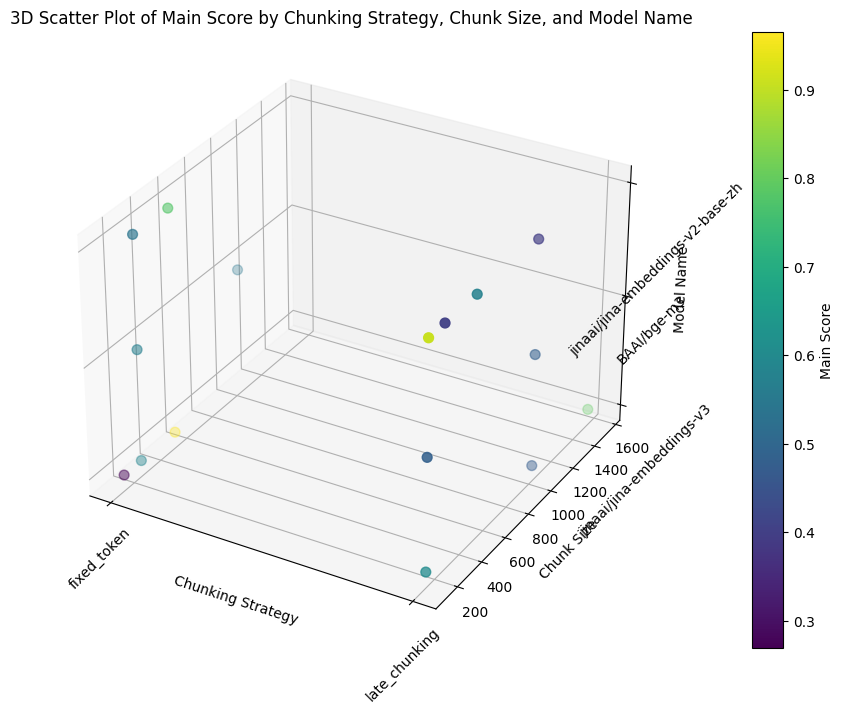

In [8]:
# Step 5: 将分类变量转为数值型编码
chunking_strategy_mapping = {strategy: idx for idx, strategy in enumerate(avg_scores['chunking_strategy'].unique())}
model_name_mapping = {model: idx for idx, model in enumerate(avg_scores['model_name'].unique())}

avg_scores['chunking_strategy_code'] = avg_scores['chunking_strategy'].map(chunking_strategy_mapping)
avg_scores['model_name_code'] = avg_scores['model_name'].map(model_name_mapping)

# Step 6: 三维图绘制
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 使用散点图绘制三维数据点
scatter = ax.scatter(
    avg_scores['chunking_strategy_code'],
    avg_scores['chunk_size'],
    avg_scores['model_name_code'],
    c=avg_scores['main_score'],
    cmap='viridis',
    s=50
)

# 添加颜色条
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Main Score')

# 设置轴标签
ax.set_xlabel('Chunking Strategy')
ax.set_ylabel('Chunk Size')
ax.set_zlabel('Model Name')

# 设置轴刻度标签
ax.set_xticks(list(chunking_strategy_mapping.values()))
ax.set_xticklabels(list(chunking_strategy_mapping.keys()), rotation=45)
ax.set_zticks(list(model_name_mapping.values()))
ax.set_zticklabels(list(model_name_mapping.keys()), rotation=45)

plt.title('3D Scatter Plot of Main Score by Chunking Strategy, Chunk Size, and Model Name')
plt.show()

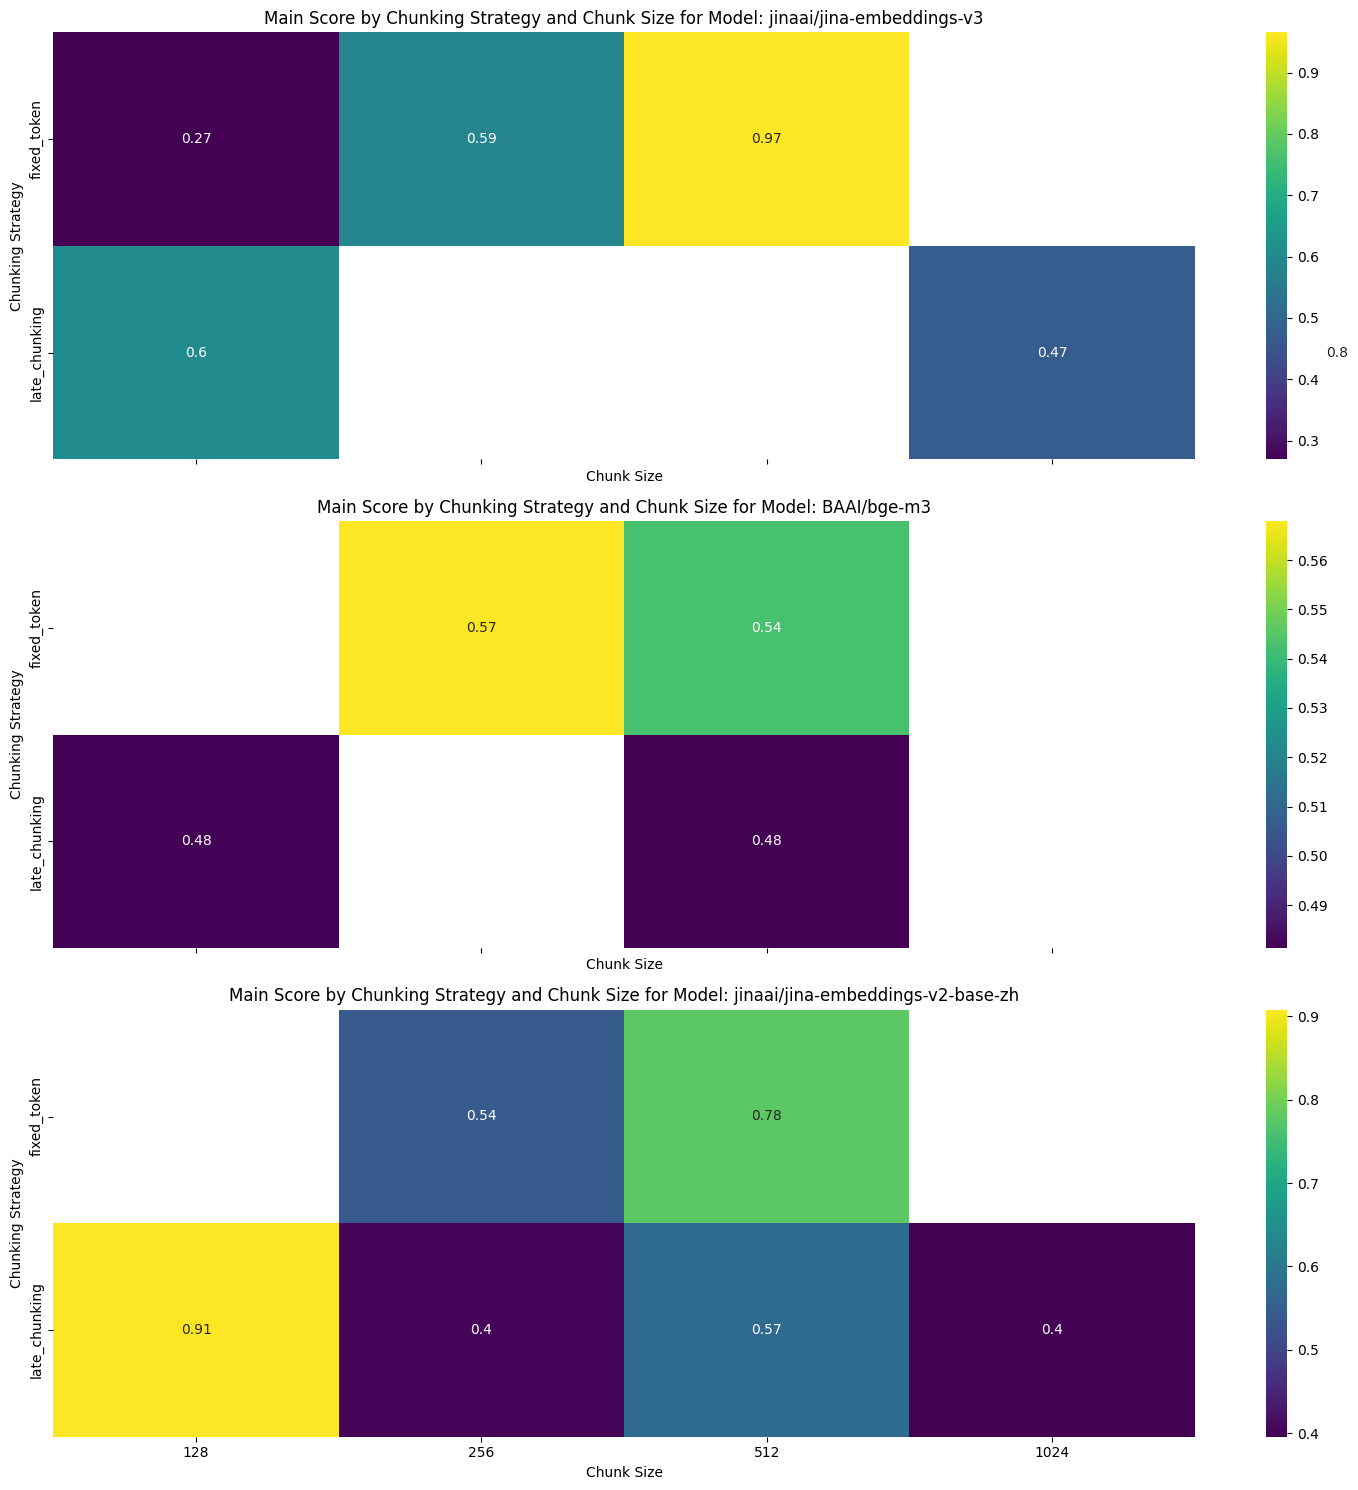

In [9]:
# Step 5: 绘制每个模型的热图
models = avg_scores['model_name'].unique()
num_models = len(models)

fig, axes = plt.subplots(num_models, 1, figsize=(15, 5 * num_models), sharex=True)

for idx, model in enumerate(models):
    model_data = avg_scores[avg_scores['model_name'] == model]
    pivot_table = model_data.pivot(index='chunking_strategy', columns='chunk_size', values='main_score')

    sns.heatmap(
        pivot_table,
        ax=axes[idx],
        annot=True,
        cmap='viridis'
    )
    axes[idx].set_title(f'Main Score by Chunking Strategy and Chunk Size for Model: {model}')
    axes[idx].set_xlabel('Chunk Size')
    axes[idx].set_ylabel('Chunking Strategy')

plt.tight_layout()
plt.show()